In [86]:
using LinearAlgebra

In [87]:
struct Parm
    μ::Float64
    t1::Float64
    t2::Float64
    Q::Float64
    J::Float64
    m::Float64
    W::Float64
    η::Float64
    Nk::Int
    dk::Float64
end

In [88]:
mutable struct Ham
    H::Matrix{ComplexF64}
    e::Vector{Float64}
    vx::Matrix{ComplexF64}
    vxx::Matrix{ComplexF64}
    vxxx::Matrix{ComplexF64}
end

In [89]:
function set_Hk(k::Float64, p::Parm)
    H = [-2p.t1*cos(k-p.Q/2)-2p.t2*cos(2*(k-p.Q/2))-p.J*p.m+p.μ -p.J*sqrt(1.0-p.m^2); -p.J*sqrt(1.0-p.m^2) -2p.t1*cos(k+p.Q/2)-2p.t2*cos(2*(k+p.Q/2))+p.J*p.m+p.μ]
    e = zeros(Float64, 2)
    vx = [2p.t1*sin(k-p.Q/2)+4p.t2*sin(2*(k-p.Q/2)) 0.0; 0.0 2p.t1*sin(k+p.Q/2)+4p.t2*sin(2*(k+p.Q/2))]
    vxx = [2p.t1*cos(k-p.Q/2)+8p.t2*cos(2*(k-p.Q/2)) 0.0; 0.0 2p.t1*cos(k+p.Q/2)+8p.t2*cos(2*(k+p.Q/2))]
    vxxx = [-2p.t1*sin(k-p.Q/2)-16p.t2*sin(2*(k-p.Q/2)) 0.0; 0.0 -2p.t1*sin(k+p.Q/2)-16p.t2*sin(2*(k+p.Q/2))]

    return H, e, vx, vxx, vxxx
end

function band_index!(h0::Ham)
    e, v = eigen(h0.H)
    h0.e = real.(e)
    h0.H = [h0.e[1] 0.0; 0.0 h0.e[2]]
    h0.vx = v' * h0.vx * v
    h0.vxx = v' * h0.vxx * v
    h0.vxxx = v' * h0.vxxx * v
end
    

band_index! (generic function with 1 method)

In [90]:
mutable struct Green
    GR::Matrix{ComplexF64}
    GRp::Matrix{ComplexF64}
    GRm::Matrix{ComplexF64}
    GA::Matrix{ComplexF64}
    GAp::Matrix{ComplexF64}
    GAm::Matrix{ComplexF64}
    GRmA::Matrix{ComplexF64}
end

In [91]:
function set_Green_BI(ω::Float64, p::Parm, h0::Ham)
    GR = [1.0/(ω-h0.e[1]+1.0im*p.η) 0.0; 0.0 1.0/(ω-h0.e[2]+1.0im*p.η)]
    GA = GR'
    GRp = [1.0/(ω+p.W-h0.e[1]+1.0im*p.η) 0.0; 0.0 1.0/(ω+p.W-h0.e[2]+1.0im*p.η)]
    GAp = GRp'
    GRm = [1.0/(ω-p.W-h0.e[1]+1.0im*p.η) 0.0; 0.0 1.0/(ω-p.W-h0.e[2]+1.0im*p.η)]
    GAm = GRm'
    GRmA = GR - GA
    return GR, GRp, GRm, GA, GAp, GAm, GRmA
end

set_Green_BI (generic function with 1 method)

In [92]:
function f(ω::Float64)
    e = 0.0
    if(ω == 0)
        e = 0.5
    elseif(ω < 0.0)
        e = 1.0
    end
    return e
end

f (generic function with 1 method)

In [158]:
function f(ω::Float64)
    T = 0.1
    e = 1.0/(1.0+exp(ω/T))
    return e
end

f (generic function with 1 method)

In [159]:
function calc_PV_Green(W_MAX::Float64, Nw::Int ,p::Parm, h::Ham)
    dw = 2W_MAX/Nw
    s = zeros(Float64, 4)
    for iw in 1:Nw
        ω = -W_MAX + dw*iw
        G = Green(set_Green_BI(ω, p, h)...)
        s[1] += dw * imag(tr(h.vxxx * G.GRmA))*f(ω)/p.W^2/(2pi)
        s[2] += dw * imag(tr(h.vxx * (G.GRp+G.GRm) * h.vx * G.GRmA + h.vxx * G.GRmA * h.vx * (G.GAp+G.GAm)))*f(ω)/p.W^2/(2pi)
        s[3] += dw * imag(tr(h.vx * G.GR * h.vxx * G.GRmA + h.vx * G.GRmA * h.vxx * G.GA))*f(ω)/p.W^2/(2pi)
        s[4] += dw * imag(tr(h.vx * G.GR * h.vx * (G.GRp+G.GRm) * h.vx * G.GRmA) + tr(h.vx * G.GRm * h.vx * G.GRmA * h.vx * G.GAm + h.vx * G.GRp * h.vx * G.GRmA * h.vx * G.GAp) + tr(h.vx * G.GRmA * h.vx * (G.GAp + G.GAm) * h.vx * G.GA))*f(ω)/p.W^2/(2pi)
    end
    return s
end

function calc_PV_BI(p::Parm, h::Ham)
    s = zeros(Float64, 4)
    for i in 1:2
        s[1] += -real(h.vxxx[i,i]) * f(h.e[i])/p.W^2
        jp = 3-i
        s[3] += -real(h.vx[i,jp] * h.vxx[jp,i]/(h.e[i]-h.e[jp]+2.0im*p.η)) * (f(h.e[i])-f(h.e[jp]))/p.W^2
        s[2] += -real(h.vxx[i,jp] * h.vx[jp,i]*(1.0/(p.W-h.e[jp]+h.e[i]+2.0im*p.η)+ 1.0/(-p.W-h.e[jp]+h.e[i]+2.0im*p.η))) * (f(h.e[i])-f(h.e[jp]))/p.W^2
        #s[3] += -real(h.vx[i,i]* h.vx[i,i]/ )* f(h.e[i])/p.W^2
        for j in 1:2
            for k in 1:2
                #=
                s[4] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                        * (f(h.e[i])/(h.e[i]-h.e[j]+1.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+1.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+1.0im*p.η))
                         + f(h.e[k])*(1.0/((-p.W-h.e[j]+h.e[k]+1.0im*p.η)*(-p.W-h.e[i]+h.e[k]-1.0im*p.η))+1.0/((p.W-h.e[j]+h.e[k]+1.0im*p.η)*(p.W-h.e[i]+h.e[k]-1.0im*p.η))) + f(h.e[j])/(h.e[i]-h.e[j]+1.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+1.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+1.0im*p.η)) ) )/p.W^2 
                =#
                #=
                s[4] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                        * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+2.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+2.0im*p.η))
                            - f(h.e[i]+p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]+p.W)/((p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η)) - f(h.e[i]-p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(-p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]-p.W)/((-p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η)) 
                            + f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+2.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+2.0im*p.η))))/p.W^2
                            =#
                s[4] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                            * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+2.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+2.0im*p.η))
                                - f(h.e[k]+p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]+p.W)/((p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η)) - f(h.e[i]-p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(-p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]-p.W)/((-p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η)) 
                                + f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+2.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+2.0im*p.η))))/p.W^2
            end
        end
    end
    return s
end
function calc_PV_BI2(p::Parm, h::Ham)
    s = zeros(Float64, 4)
    for i in 1:2
        s[1] += -real(h.vxxx[i,i]) * f(h.e[i])/p.W^2
        jp = 3-i
        s[3] += -real(h.vx[i,jp] * h.vxx[jp,i]/(h.e[i]-h.e[jp]+1.0im*p.η)) * (f(h.e[i])-f(h.e[jp]))/p.W^2
        s[2] += -real(h.vxx[i,jp] * h.vx[jp,i]*(1.0/(p.W-h.e[jp]+h.e[i]+1.0im*p.η)+ 1.0/(-p.W-h.e[jp]+h.e[i]+1.0im*p.η))) * (f(h.e[i])-f(h.e[jp]))/p.W^2
        #s[3] += -real(h.vx[i,i]* h.vx[i,i]/ )* f(h.e[i])/p.W^2
        for j in 1:2
            for k in 1:2
                s[4] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                        * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+1.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+1.0im*p.η))
                         + f(h.e[k])*(1.0/((-p.W-h.e[j]+h.e[k]+1.0im*p.η)*(-p.W-h.e[i]+h.e[k]-1.0im*p.η))+1.0/((p.W-h.e[j]+h.e[k]+1.0im*p.η)*(p.W-h.e[i]+h.e[k]-1.0im*p.η))) + f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+1.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+1.0im*p.η)) ) )/p.W^2 
            end
        end
    end
    return s
end
function calc_PV_BI3(p::Parm, h::Ham)
    s = zeros(Float64, 4)
    for i in 1:2
        s[1] += -real(h.vxxx[i,i]) * f(h.e[i])/p.W^2
        jp = 3-i
        s[3] += -real(h.vx[i,jp] * h.vxx[jp,i]/(h.e[i]-h.e[jp]+2.0im*p.η)) * (f(h.e[i])-f(h.e[jp]))/p.W^2
        s[2] += -real(h.vxx[i,jp] * h.vx[jp,i]*(1.0/(p.W-h.e[jp]+h.e[i]+2.0im*p.η)+ 1.0/(-p.W-h.e[jp]+h.e[i]+2.0im*p.η))) * (f(h.e[i])-f(h.e[jp]))/p.W^2
        #s[3] += -real(h.vx[i,i]* h.vx[i,i]/ )* f(h.e[i])/p.W^2
        for j in 1:2
            for k in 1:2
                s[4] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                        * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+2.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+2.0im*p.η))
                         + f(h.e[k])*(1.0/((-p.W-h.e[j]+h.e[k]+2.0im*p.η)*(-p.W-h.e[i]+h.e[k]-2.0im*p.η))+1.0/((p.W-h.e[j]+h.e[k]+2.0im*p.η)*(p.W-h.e[i]+h.e[k]-2.0im*p.η))) + f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+2.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+2.0im*p.η)) ) )/p.W^2 
            end
        end
    end
    return s
end

calc_PV_BI3 (generic function with 1 method)

In [94]:
ww = zeros(Float64, NW)
for iW in 1:NW
    ww[iW] = 4.0*iW/NW
end

In [162]:
Wm = 5.0
Nw = 5000
NW = 50
s_G = zeros(Float64, NW, 4)
s_BI = zeros(Float64, NW, 4)
s_BI2 = zeros(Float64, NW, 4)
for iW in 1:NW
    W = 7.0*iW/NW
    p0 = Parm(0.0, 1.0, -0.1, pi/4, 3.0, 0.2, W, 0.02, 1000, 2pi/1000)
    for ik in 1:p0.Nk
        k = p0.dk*ik
        H = Ham(set_Hk(k,p0)...)
        band_index!(H)
        s_G[iW,:] += p0.dk * calc_PV_Green(Wm, Nw, p0, H)/(2pi)
        s_BI[iW,:] += p0.dk * calc_PV_BI(p0, H)/(2pi)
        s_BI2[iW,:] += p0.dk * calc_PV_BI2(p0, H)/(2pi)
    end
end

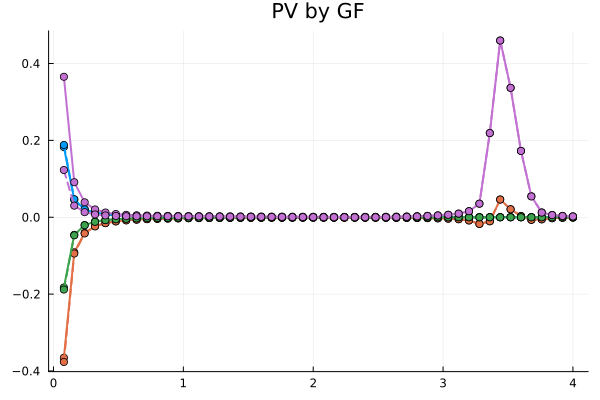

In [163]:
plot(ww, s_G[:,1],title="PV by GF", label="s1", width=2.0, marker=:circle, legend=nothing)
plot!(ww, s_BI[:,1], width=2.0, style=:dash, label="s1_BI", color=1, marker=:circle)
#plot!(ww, s_BI2[:,1], width=2.0, style=:dash, label="s1_parker", color=1, marker=:square)
plot!(ww, s_G[:,2], width=2.0, label="s2", marker=:circle, color=2)
plot!(ww, s_BI[:,2], width=2.0, style=:dash, label="s2_BI", color=2, marker=:circle)
plot!(ww, s_G[:,3], width=2.0, label="s3", marker=:circle, color=3)
plot!(ww, s_BI[:,3], width=2.0, style=:dash, label="s3_BI", color=3, marker=:circle)
plot!(ww, s_G[:,4], width=2.0, label="s4", marker=:circle, color=4)
plot!(ww, s_BI[:,4], width=2.0, style=:dash, label="s4_BI", color=4, marker=:circle)
#plot!(ww, s_BI2[:,4], width=2.0, style=:dash, label="s4_BI", color=4, marker=:circle)
#plot!(ww, s_G[:,2]+s_G[:,4], width=2.0, label="s2+s4", marker=:circle, color=5)

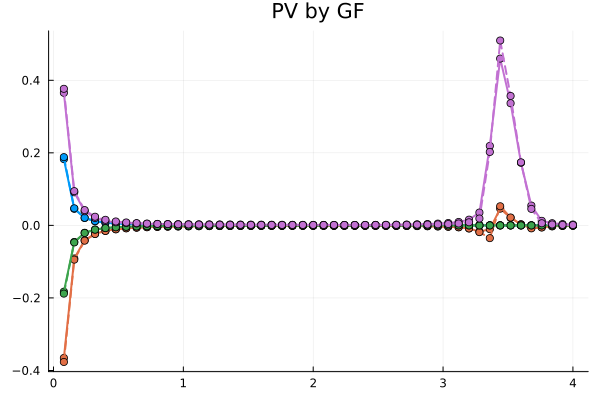

In [167]:
plot(ww, s_G[:,1],title="PV by GF", label="s1", width=2.0, marker=:circle, legend=nothing)
plot!(ww, s_BI2[:,1], width=2.0, style=:dash, label="s1_BI_parker", color=1, marker=:circle)
#plot!(ww, s_BI2[:,1], width=2.0, style=:dash, label="s1_parker", color=1, marker=:square)
plot!(ww, s_G[:,2], width=2.0, label="s2", marker=:circle, color=2)
plot!(ww, s_BI2[:,2], width=2.0, style=:dash, label="s2_BI_parker", color=2, marker=:circle)
plot!(ww, s_G[:,3], width=2.0, label="s3", marker=:circle, color=3)
plot!(ww, s_BI2[:,3], width=2.0, style=:dash, label="s3_BI_parker", color=3, marker=:circle)
plot!(ww, s_G[:,4], width=2.0, label="s4", marker=:circle, color=4)
plot!(ww, s_BI2[:,4], width=2.0, style=:dash, label="s4_BI_parker", color=4, marker=:circle)

In [174]:
kx=range(-pi,pi,length=200)

-3.141592653589793:0.03157379551346526:3.141592653589793

In [175]:
kx[1] + pi

0.0

In [97]:
function calc_PV_Green_4(W_MAX::Float64, Nw::Int ,p::Parm, h::Ham)
    dw = 2W_MAX/Nw
    s = zeros(Float64, 2, 2, 2)
    for iw in 1:Nw
        ω = -W_MAX + dw*iw
        G = Green(set_Green_BI(ω, p, h)...)
        #s[1] += dw * imag(tr(h.vxxx * G.GRmA))*f(ω)/p.W^2/(2pi)
        #s[2] += dw * imag(tr(h.vxx * (G.GRp+G.GRm) * h.vx * G.GRmA + h.vxx * G.GRmA * h.vx * (G.GAp+G.GAm)))*f(ω)/p.W^2/(2pi)
        #s[3] += dw * imag(tr(h.vx * G.GR * h.vxx * G.GRmA + h.vx * G.GRmA * h.vxx * G.GA))*f(ω)/p.W^2/(2pi)
        for i in 1:2, j in 1:2, k in 1:2
            s[i,j,k] += dw * imag(h.vx[i,j] * h.vx[j,k] * h.vx[k,i] * (G.GR[j,j] * (G.GRp+G.GRm)[k,k] * G.GRmA[i,i] + G.GRm[j,j] * G.GRmA[k,k] * G.GAm[i,i] + G.GRp[j,j] * G.GRmA[k,k] * G.GAp[i,i] + G.GRmA[j,j] * (G.GAp + G.GAm)[k,k] * G.GA[i,i]))*f(ω)/p.W^2/(2pi)
        end
    end
    return s
end

function calc_PV_BI_4(p::Parm, h::Ham)
    s = zeros(Float64, 2, 2, 2)
    for i in 1:2, j in 1:2, k in 1:2
        s[i,j,k] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+2.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+2.0im*p.η))
                    - f(h.e[i]+p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]+p.W)/((p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η)) - f(h.e[i]-p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(-p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]-p.W)/((-p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η)) 
                    + f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+2.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+2.0im*p.η))))/p.W^2 
    end
    return s
end
function calc_PV_BI_4_2(p::Parm, h::Ham)
    s = zeros(Float64, 2, 2, 2)
    for i in 1:2, j in 1:2, k in 1:2
        s[i,j,k] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i] * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+2.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+2.0im*p.η)) + f(h.e[k])*(1.0/((-p.W-h.e[j]+h.e[k]+2.0im*p.η)*(-p.W-h.e[i]+h.e[k]-2.0im*p.η))+1.0/((p.W-h.e[j]+h.e[k]+2.0im*p.η)*(p.W-h.e[i]+h.e[k]-2.0im*p.η))) + f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+2.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+2.0im*p.η)) ) )/p.W^2 
    end
    return s
end
function calc_PV_BI_4_3(p::Parm, h::Ham)
    s = zeros(Float64, 2, 2, 2)
    for i in 1:2, j in 1:2, k in 1:2
        s[i,j,k] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
        * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+1.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+1.0im*p.η))
            + f(h.e[k])*(1.0/((-p.W-h.e[j]+h.e[k]+1.0im*p.η)*(-p.W-h.e[i]+h.e[k]-1.0im*p.η))+1.0/((p.W-h.e[j]+h.e[k]+1.0im*p.η)*(p.W-h.e[i]+h.e[k]-1.0im*p.η))) + f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+1.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+1.0im*p.η)) ) )/p.W^2 
    end
    return s
end

calc_PV_BI_4_3 (generic function with 1 method)

In [98]:
Wm = 5.0
Nw = 2000
NW = 50
#s_G_4 = zeros(Float64, NW, 2, 2, 2)
s_BI_4 = zeros(Float64, NW, 2, 2, 2)
s_BI2_4 = zeros(Float64, NW, 2, 2, 2)
s_BI3_4 = zeros(Float64, NW, 2, 2, 2)
for iW in 1:NW
    W = 7.0*iW/NW
    p0 = Parm(0.0, 1.0, -0.1, pi/4, 3.0, 0.2, W, 0.02, 500, 2pi/500)
    for ik in 1:p0.Nk
        k = p0.dk*ik
        H = Ham(set_Hk(k,p0)...)
        band_index!(H)
        #s_G_4[iW,:,:,:] += p0.dk * calc_PV_Green_4(Wm, Nw, p0, H)/(2pi)
        s_BI_4[iW,:,:,:] += p0.dk * calc_PV_BI_4(p0, H)/(2pi)
        s_BI2_4[iW,:,:,:] += p0.dk * calc_PV_BI_4_2(p0, H)/(2pi)
        s_BI3_4[iW,:,:,:] += p0.dk * calc_PV_BI_4_3(p0, H)/(2pi)
    end
end

In [99]:
s_tot = zeros(Float64, NW)
s_tot_BI = zeros(Float64, NW)
for w in 1:NW
    for i in 1:2, j in 1:2, k in 1:2
        s_tot[w] += s_G_4[w,i,j,k]
        s_tot_BI[w] += s_BI2_4[w,i,j,k]
        
    end
    #s_tot_BI[w] += s_BI_4[w,2,2,1]
end

In [100]:
using Plots

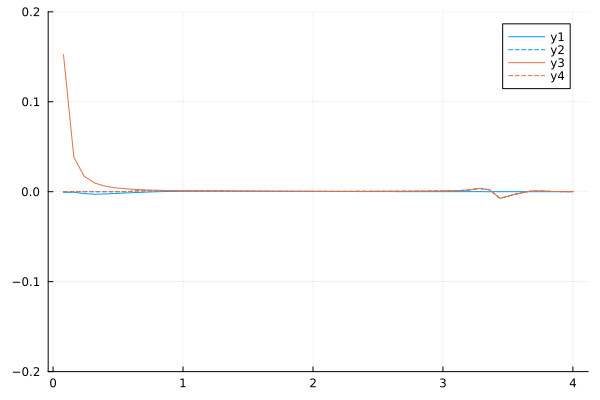

In [101]:
plot(ww, s_G_4[:,1,1,1], color=1, yrange=(-0.2,0.2))
plot!(ww, s_BI_4[:,1,2,2], style=:dash, color=1)
plot!(ww, s_G_4[:,2,1,2], color=2)
plot!(ww, s_BI_4[:,2,1,2], style=:dash, color=2)
#plot!(ww, s_G_4[:,1,2,2], width=7.0)
#plot!(ww, s_G_4[:,2,1,1])
#plot!(ww, s_G_4[:,2,1,2], width=4.0)
#plot!(ww, s_G_4[:,2,2,1], width=2.0)
#plot!(ww, s_G_4[:,2,2,2])

In [102]:
function calc_PV_Green_4(i::Int, j::Int, k::Int,W_MAX::Float64, Nw::Int ,p::Parm, h::Ham)
    dw = 2W_MAX/Nw
    s = zeros(Float64, 3)
    for iw in 1:Nw
        ω = -W_MAX + dw*iw
        G = Green(set_Green_BI(ω, p, h)...)
        #s[1] += dw * imag(tr(h.vxxx * G.GRmA))*f(ω)/p.W^2/(2pi)
        #s[2] += dw * imag(tr(h.vxx * (G.GRp+G.GRm) * h.vx * G.GRmA + h.vxx * G.GRmA * h.vx * (G.GAp+G.GAm)))*f(ω)/p.W^2/(2pi)
        #s[3] += dw * imag(tr(h.vx * G.GR * h.vxx * G.GRmA + h.vx * G.GRmA * h.vxx * G.GA))*f(ω)/p.W^2/(2pi)
        s[1] += dw * imag(h.vx[i,j] * h.vx[j,k] * h.vx[k,i] * (G.GR[j,j] * (G.GRp+G.GRm)[k,k] * G.GRmA[i,i]))*f(ω)/p.W^2/(2pi)
        s[2] += dw * imag(h.vx[i,j] * h.vx[j,k] * h.vx[k,i] * (G.GRm[j,j] * G.GRmA[k,k] * G.GAm[i,i] + G.GRp[j,j] * G.GRmA[k,k] * G.GAp[i,i]))*f(ω)/p.W^2/(2pi)
        s[3] += dw * imag(h.vx[i,j] * h.vx[j,k] * h.vx[k,i] * (G.GRmA[j,j] * (G.GAp + G.GAm)[k,k] * G.GA[i,i]))*f(ω)/p.W^2/(2pi)
    end
    return s
end

function calc_PV_BI_4(i::Int, j::Int, k::Int,p::Parm, h::Ham)
    s = zeros(Float64, 3)
    s[1] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+2.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+2.0im*p.η))))/p.W^2
    s[2] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                * (- f(h.e[i]+p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]+p.W)/((p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η)) - f(h.e[i]-p.W)/((h.e[i]-h.e[j]+2.0im*p.η)*(-p.W+h.e[i]-h.e[k]+2.0im*p.η))-f(h.e[j]-p.W)/((-p.W+h.e[j]-h.e[k]-2.0im*p.η)*(h.e[j]-h.e[i]-2.0im*p.η))))/p.W^2 
    s[3] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                * (f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+2.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+2.0im*p.η))))/p.W^2 
    return s
end

function calc_PV_BI_4_2(i::Int, j::Int, k::Int,p::Parm, h::Ham)
    s = zeros(Float64, 3)
    s[1] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                * (f(h.e[i])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(p.W+h.e[i]-h.e[k]+1.0im*p.η)+1.0/(-p.W+h.e[i]-h.e[k]+1.0im*p.η))))/p.W^2
    s[2] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                * (f(h.e[k])*(1.0/((-p.W-h.e[j]+h.e[k]+1.0im*p.η)*(-p.W-h.e[i]+h.e[k]-1.0im*p.η))+1.0/((p.W-h.e[j]+h.e[k]+1.0im*p.η)*(p.W-h.e[i]+h.e[k]-1.0im*p.η)))))/p.W^2 
    s[3] += -real(h.vx[i,j] * h.vx[j,k] * h.vx[k,i]
                * (f(h.e[j])/(h.e[i]-h.e[j]+2.0im*p.η)*(1.0/(-p.W+h.e[k]-h.e[j]+1.0im*p.η)+1.0/(p.W+h.e[k]-h.e[j]+1.0im*p.η))))/p.W^2
    return s
end

calc_PV_BI_4_2 (generic function with 2 methods)

In [103]:
Wm = 5.0
Nw = 2000
NW = 50
s_G_4x = zeros(Float64, NW, 3)
s_BI_4x = zeros(Float64, NW, 3)
s_BI2_4x = zeros(Float64, NW, 3)
x1=2
x2=1
x3=1
for iW in 1:NW
    W = 7.0*iW/NW
    p0 = Parm(0.0, 1.0, -0.1, pi/4, 3.0, 0.2, W, 0.02, 500, 2pi/500)
    for ik in 1:p0.Nk
        k = p0.dk*ik
        H = Ham(set_Hk(k,p0)...)
        band_index!(H)
        s_G_4x[iW,:,:,:] += p0.dk * calc_PV_Green_4(x1,x2,x3,Wm, Nw, p0, H)/(2pi)
        s_BI_4x[iW,:] += p0.dk * calc_PV_BI_4(x1,x2,x3,p0, H)/(2pi)
        s_BI2_4x[iW,:] += p0.dk * calc_PV_BI_4_2(x1,x2,x3,p0, H)/(2pi)
        #s_BI3_4x[iW,:] += p0.dk * calc_PV_BI_4_3(p0, H)/(2pi)
    end
end

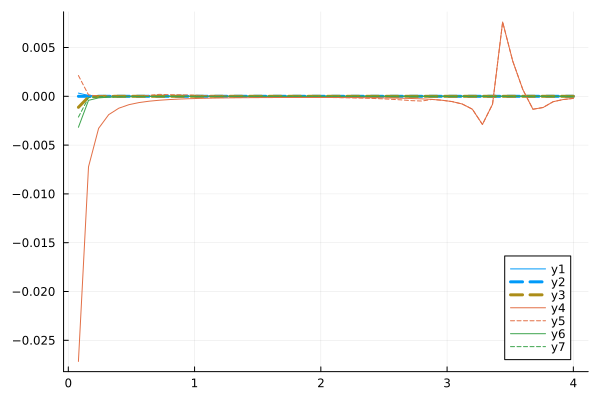

In [104]:
plot(ww, s_G_4x[:,1], color=1)
plot!(ww, s_BI_4x[:,1], style=:dash, color=1, width=3.0)
plot!(ww, s_BI2_4x[:,3], style=:dash, color=5, width=3.0)
plot!(ww, s_G_4x[:,2], color=2)
plot!(ww, s_BI_4x[:,2], style=:dash, color=2)
#plot!(ww, s_BI2_4[:,2,2,1], style=:dash, color=2)
plot!(ww, s_G_4x[:,3], color=3)
plot!(ww, s_BI_4x[:,3], style=:dash, color=3)
#plot!(ww, s_G_4[:,1,2,2], color=4)

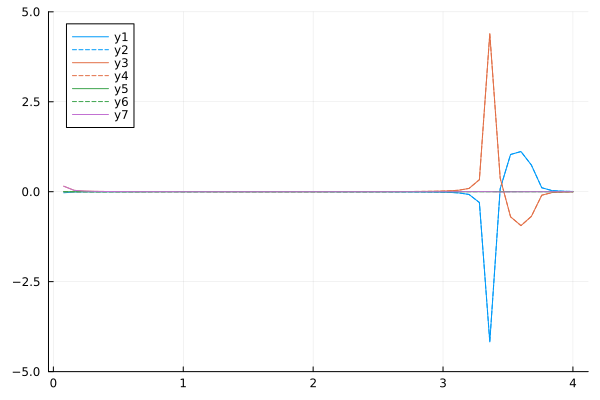

In [105]:
plot(ww, s_G_4[:,1,1,2], color=1, yrange=(-5.0,5.0))
plot!(ww, s_BI_4[:,1,1,2], style=:dash, color=1)
plot!(ww, s_G_4[:,2,2,1], color=2)
plot!(ww, s_BI_4[:,2,2,1], style=:dash, color=2)
#plot!(ww, s_BI2_4[:,2,2,1], style=:dash, color=2)
plot!(ww, s_G_4[:,1,1,1], color=3)
plot!(ww, s_BI_4[:,1,1,1], style=:dash, color=3)
plot!(ww, s_G_4[:,1,2,2], color=4)
#plot!(ww, s_BI2_4[:,2,2,2], style=:dash, color=4)
#plot!(ww, s_tot, color=5)
#plot!(ww, s_tot_BI, style=:dash, color=5)

In [106]:
function calc_PV_Green_112(W_MAX::Float64, Nw::Int ,p::Parm, h::Ham)
    dw = 2W_MAX/Nw
    s = zeros(Float64, 3)
    for iw in 1:Nw
        ω = -W_MAX + dw*iw
        G = Green(set_Green_BI(ω, p, h)...)
        s[1] += dw * imag(h.vx[1,1] * h.vx[1,2] * h.vx[2,1] * G.GR[1,1] * (G.GRp+G.GRm)[2,2] * G.GRmA[1,1])*f(ω)/p.W^2/(2pi)
        s[2] += dw * imag(h.vx[1,1] * h.vx[1,2] * h.vx[2,1] * (G.GRm[1,1] * G.GRmA[2,2] * G.GAm[1,1] + G.GRp[1,1] * G.GRmA[2,2] * G.GAp[1,1]))*f(ω)/p.W^2/(2pi)
        s[3] += dw * imag(h.vx[1,1] * h.vx[1,2] * h.vx[2,1] * G.GRmA[1,1] * (G.GAp + G.GAm)[2,2] * G.GA[1,1])*f(ω)/p.W^2/(2pi)
    end
    return s
end

function calc_PV_BI_112(p::Parm, h::Ham)
    s = zeros(Float64, 3)
    
    s[1] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[1])/(h.e[1]-h.e[1]+1.0im*p.η)*(1.0/(p.W+h.e[1]-h.e[2]+1.0im*p.η)+1.0/(-p.W+h.e[1]-h.e[2]+1.0im*p.η))) )/p.W^2 
    s[2] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[2])*(1.0/((-p.W-h.e[1]+h.e[2]+1.0im*p.η)*(-p.W-h.e[1]+h.e[2]-1.0im*p.η))+1.0/((p.W-h.e[1]+h.e[2]+1.0im*p.η)*(p.W-h.e[1]+h.e[2]-1.0im*p.η))) ) )/p.W^2 
    s[3] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[1])/(h.e[1]-h.e[1]+1.0im*p.η)*(1.0/(-p.W+h.e[2]-h.e[1]+1.0im*p.η)+1.0/(p.W+h.e[2]-h.e[1]+1.0im*p.η)) ) )/p.W^2 
    return s
end
function calc_PV_BI_112_2(p::Parm, h::Ham)
    s = zeros(Float64, 3)
    
    s[1] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[1])/(h.e[1]-h.e[1]+2.0im*p.η)*(1.0/(p.W+h.e[1]-h.e[2]+1.0im*p.η)+1.0/(-p.W+h.e[1]-h.e[2]+1.0im*p.η))) )/p.W^2 
    s[2] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[2])*(1.0/((-p.W-h.e[1]+h.e[2]+1.0im*p.η)*(-p.W-h.e[1]+h.e[2]-1.0im*p.η))+1.0/((p.W-h.e[1]+h.e[2]+1.0im*p.η)*(p.W-h.e[1]+h.e[2]-1.0im*p.η))) ) )/p.W^2 
    s[3] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[1])/(h.e[1]-h.e[1]+2.0im*p.η)*(1.0/(-p.W+h.e[2]-h.e[1]+1.0im*p.η)+1.0/(p.W+h.e[2]-h.e[1]+1.0im*p.η)) ) )/p.W^2 
    return s
end
function calc_PV_BI_112_3(p::Parm, h::Ham)
    s = zeros(Float64, 3)
    
    s[1] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[1])/(h.e[1]-h.e[1]+2.0im*p.η)*(1.0/(p.W+h.e[1]-h.e[2]+2.0im*p.η)+1.0/(-p.W+h.e[1]-h.e[2]+2.0im*p.η))) )/p.W^2 
    s[2] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[2])*(1.0/((-p.W-h.e[1]+h.e[2]+2.0im*p.η)*(-p.W-h.e[1]+h.e[2]-2.0im*p.η))+1.0/((p.W-h.e[1]+h.e[2]+2.0im*p.η)*(p.W-h.e[1]+h.e[2]-2.0im*p.η))) ) )/p.W^2 
    s[3] += -real(h.vx[1,1] * h.vx[1,2] * h.vx[2,1]
                * (f(h.e[1])/(h.e[1]-h.e[1]+2.0im*p.η)*(1.0/(-p.W+h.e[2]-h.e[1]+2.0im*p.η)+1.0/(p.W+h.e[2]-h.e[1]+2.0im*p.η)) ) )/p.W^2 
    return s
end

calc_PV_BI_112_3 (generic function with 1 method)

In [107]:
#s_G_112 = zeros(Float64, NW, 3)
s_BI_112 = zeros(Float64, NW, 3)
s_BI2_112 = zeros(Float64, NW, 3)
s_BI3_112 = zeros(Float64, NW, 3)
for iW in 1:NW
    W = 7.0*iW/NW
    p0 = Parm(0.0, 1.0, -0.1, pi/4, 3.0, 0.2, W, 0.02, 500, 2pi/500)
    for ik in 1:p0.Nk
        k = p0.dk*ik
        H = Ham(set_Hk(k,p0)...)
        band_index!(H)
        #s_G_4[iW,:,:,:] += p0.dk * calc_PV_Green_4(Wm, Nw, p0, H)/(2pi)
        #s_G_112[iW,:] += p0.dk * calc_PV_Green_112(Wm, Nw, p0, H)/(2pi)
        s_BI_112[iW,:] += p0.dk * calc_PV_BI_112_3(p0, H)/(2pi)
        s_BI2_112[iW,:] += p0.dk * calc_PV_BI_112_2(p0, H)/(2pi)
        s_BI3_112[iW,:] += p0.dk * calc_PV_BI_112(p0, H)/(2pi)
    end
end

In [108]:
plot(ww, s_G_112[:,1], color=3, marker=:circle, width=3.0, label="112_Green")
plot!(ww, s_BI2_112[:,1], color=2, marker=:circle, label="112_parker")
plot!(ww, s_BI_112[:,1], color=1, marker=:circle,label="112_true")
plot!(ww, s_BI3_112[:,1], color=4, marker=:circle, label="112_old")
#plot!(ww, s_G_112[:,2], color=3)
#plot!(ww, s_BI_112[:,2], style=:dash, color=3)

LoadError: UndefVarError: s_G_112 not defined

In [ ]:
function calc_PV_Green_221(W_MAX::Float64, Nw::Int ,p::Parm, h::Ham)
    dw = 2W_MAX/Nw
    s = zeros(Float64, 3)
    for iw in 1:Nw
        ω = -W_MAX + dw*iw
        G = Green(set_Green_BI(ω, p, h)...)
        s[1] += dw * imag(h.vx[2,2] * h.vx[2,1] * h.vx[1,2] * G.GR[2,2] * (G.GRp+G.GRm)[1,1] * G.GRmA[2,2])*f(ω)/p.W^2/(2pi)
        s[2] += dw * imag(h.vx[2,2] * h.vx[2,1] * h.vx[1,2] * (G.GRm[2,2] * G.GRmA[1,1] * G.GAm[2,2] + G.GRp[2,2] * G.GRmA[1,1] * G.GAp[2,2]))*f(ω)/p.W^2/(2pi)
        s[3] += dw * imag(h.vx[2,2] * h.vx[2,1] * h.vx[1,2] * G.GRmA[2,2] * (G.GAp + G.GAm)[1,1] * G.GA[2,2])*f(ω)/p.W^2/(2pi)
    end
    return s
end
function calc_PV_BI_221_h(p::Parm, h::Ham)
    s = zeros(Float64, 3)
    
    s[1] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[2])/(h.e[2]-h.e[2]+1.0im*p.η)*(1.0/(p.W+h.e[2]-h.e[1]+2.0im*p.η)+1.0/(-p.W+h.e[2]-h.e[1]+2.0im*p.η))) )/p.W^2 
    s[2] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[2]+p.W)*(2.0/((2.0im*p.η)*(p.W+h.e[2]-h.e[1]+2.0im*p.η))) + f(h.e[2]-p.W)*(2.0/((2.0im*p.η)*(-p.W+h.e[2]-h.e[1]+2.0im*p.η)))) )/p.W^2 
    s[3] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[2])/(h.e[2]-h.e[2]+2.0im*p.η)*(1.0/(-p.W+h.e[1]-h.e[2]+2.0im*p.η)+1.0/(p.W+h.e[1]-h.e[2]+2.0im*p.η)) ) )/p.W^2 
    return s
end
function calc_PV_BI_221_2(p::Parm, h::Ham)
    s = zeros(Float64, 3)
    
    s[1] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[2])/(h.e[2]-h.e[2]+2.0im*p.η)*(1.0/(p.W+h.e[2]-h.e[1]+1.0im*p.η)+1.0/(-p.W+h.e[2]-h.e[1]+1.0im*p.η))) )/p.W^2 
    s[2] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[1])*(1.0/((-p.W-h.e[2]+h.e[1]+1.0im*p.η)*(-p.W-h.e[2]+h.e[1]-1.0im*p.η))+1.0/((p.W-h.e[2]+h.e[1]+1.0im*p.η)*(p.W-h.e[2]+h.e[1]-1.0im*p.η))) ) )/p.W^2 
    s[3] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[2])/(h.e[2]-h.e[2]+2.0im*p.η)*(1.0/(-p.W+h.e[1]-h.e[2]+1.0im*p.η)+1.0/(p.W+h.e[1]-h.e[2]+1.0im*p.η)) ) )/p.W^2 
    return s
end
function calc_PV_BI_221_3(p::Parm, h::Ham)
    s = zeros(Float64, 3)
    
    s[1] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[2])/(h.e[2]-h.e[2]+2.0im*p.η)*(1.0/(p.W+h.e[2]-h.e[1]+2.0im*p.η)+1.0/(-p.W+h.e[2]-h.e[1]+2.0im*p.η))) )/p.W^2 
    s[2] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[1])*(1.0/((-p.W-h.e[2]+h.e[1]+2.0im*p.η)*(-p.W-h.e[2]+h.e[1]-2.0im*p.η))+1.0/((p.W-h.e[2]+h.e[1]+2.0im*p.η)*(p.W-h.e[2]+h.e[1]-2.0im*p.η))) ) )/p.W^2 
    s[3] += -real(h.vx[2,2] * h.vx[2,1] * h.vx[1,2]
                * (f(h.e[2])/(h.e[2]-h.e[2]+2.0im*p.η)*(1.0/(-p.W+h.e[1]-h.e[2]+2.0im*p.η)+1.0/(p.W+h.e[1]-h.e[2]+2.0im*p.η)) ) )/p.W^2 
    return s
end

calc_PV_BI_221_3 (generic function with 1 method)

In [ ]:
#s_G_221 = zeros(Float64, NW, 3)
s_BI_221 = zeros(Float64, NW, 3)
s_BI2_221 = zeros(Float64, NW, 3)
for iW in 1:NW
    W = 7.0*iW/NW
    p0 = Parm(0.0, 1.0, -0.1, pi/4, 3.0, 0.2, W, 0.02, 500, 2pi/500)
    for ik in 1:p0.Nk
        k = p0.dk*ik
        H = Ham(set_Hk(k,p0)...)
        band_index!(H)
        #s_G_4[iW,:,:,:] += p0.dk * calc_PV_Green_4(Wm, Nw, p0, H)/(2pi)
        #s_G_221[iW,:] += p0.dk * calc_PV_Green_221(Wm, Nw, p0, H)/(2pi)
        s_BI_221[iW,:] += p0.dk * calc_PV_BI_221_3(p0, H)/(2pi)
        s_BI2_221[iW,:] += p0.dk * calc_PV_BI_221_h(p0, H)/(2pi)
    end
end

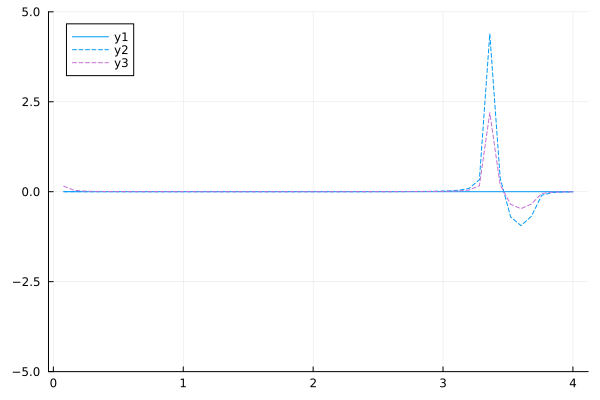

In [ ]:
plot(ww, s_BI_221[:,1], color=1, yrange=(-5.0,5.0))
plot!(ww, -s_BI2_221[:,2], style=:dash, color=1)
#plot!(ww, s_G_221[:,2], color=2)
#plot!(ww, s_G_221[:,2], color=3)
plot!(ww, s_BI_221[:,2], style=:dash, color=4)

In [ ]:
for i in 1:2, j in 1:2, k in 1:2
    print("a")
end

aaaaaaaa

In [ ]:
p = Parm(0.0, 1.0, -0.1, pi/4, 3.0, 0.2, 4.0, 0.01, 500, 2pi/500)


Parm(0.0, 1.0, -0.1, 0.7853981633974483, 3.0, 0.2, 4.0, 0.01, 500, 0.012566370614359173)

In [ ]:
ee = zeros(Float64, p.Nk, 2)
for ik in 1:p.Nk
    k = p.dk*ik
    H = Ham(set_Hk(k,p)...)
    band_index!(H)
    ee[ik,:] = H.e
end

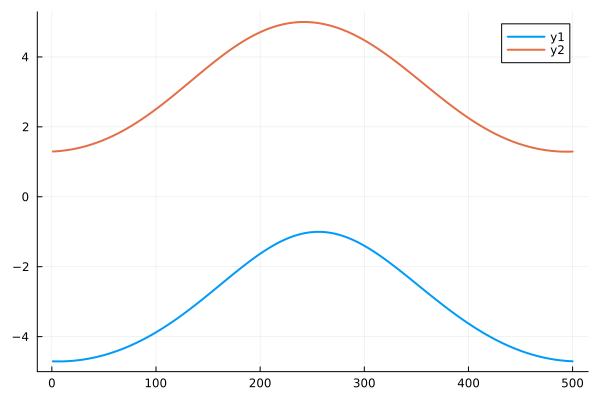

In [ ]:
plot(ee[:,1], width=2.0)
plot!(ee[:,2], width=2.0)

In [ ]:
function f(ω::Float64)
    T = 0.05
    e = 1.0/(1.0+exp(ω/T))
    return e
end

f (generic function with 1 method)

In [ ]:
using Plots

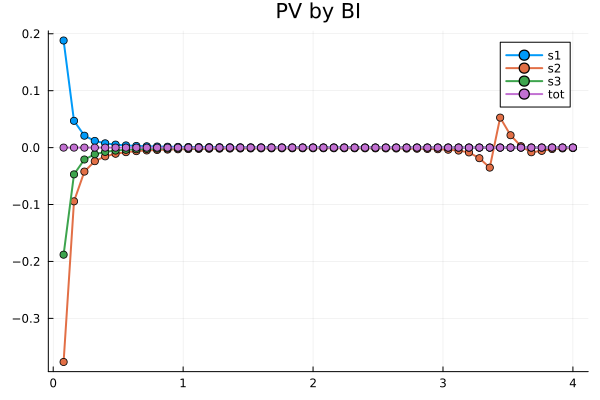

In [ ]:
plot(ww, s_BI[:,1],title="PV by BI", label="s1", width=2.0, marker=:circle)
plot!(ww, s_BI[:,2], width=2.0, label="s2", marker=:circle)
plot!(ww, s_BI[:,3], width=2.0, label="s3", marker=:circle)
#plot!(ww, s_BI[:,4], width=2.0, label="s4", marker=:circle)
plot!(ww, s_BI[:,1]+s_BI[:,3], width=2.0, label="tot", marker=:circle)
#plot!(ww, s_BI[:,1]+s_BI[:,2]+s_BI[:,3]+s_BI[:,4], width=2.0, label="tot", marker=:circle)